# Qubit Tune-up with a single SHFQC 


## 0. General Imports and Definitions
### 0.1 Python Imports 

In [1]:
# LabOne Q:
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# descriptor imports
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)

from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_shfqc_hdawg_pqsc import (
    descriptor_shfsg_shfqa_shfqc_hdawg_pqsc,
)

from laboneq.contrib.example_helpers.randomized_benchmarking_helper import (
    make_pauli_gate_map,
    clifford_parametrized,
    generate_play_rb_pulses,
)

from laboneq.contrib.example_helpers.feedback_helper import (
    state_emulation_pulse,
    create_calibration_experiment,
    create_discrimination_experiment,
)

from laboneq.contrib.example_helpers.generate_example_datastore import (
    generate_example_datastore,
    get_first_named_entry,
)

from zhinst.utils.shfqa.multistate import QuditSettings
from laboneq.analysis import calculate_integration_kernels
# for saving results and pulse sheets
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np

## 1. Define the Instrument Setup and Required Experimental Parameters
### 1.1 Create device setup

Create the device setup from the descriptor, and apply some convenient mapping to instruments and logical signals.

In [ ]:
# pip install --upgrade laboneq

In [2]:
descriptor = """\
instruments:
  SHFQC:
  - address: DEV12108
    uid: device_shfqc

connections:
  device_shfqc:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: q0/drive_line_ef
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: q1/drive_line
      ports: SGCHANNELS/1/OUTPUT
    - iq_signal: q1/drive_line_ef
      ports: SGCHANNELS/1/OUTPUT
    - iq_signal: q2/drive_line
      ports: SGCHANNELS/2/OUTPUT
    - iq_signal: q2/drive_line_ef
      ports: SGCHANNELS/2/OUTPUT
    - iq_signal: q3/drive_line
      ports: SGCHANNELS/3/OUTPUT
    - iq_signal: q3/drive_line_ef
      ports: SGCHANNELS/3/OUTPUT
    - iq_signal: q4/drive_line
      ports: SGCHANNELS/4/OUTPUT
    - iq_signal: q4/drive_line_ef
      ports: SGCHANNELS/4/OUTPUT
    - iq_signal: q5/drive_line
      ports: SGCHANNELS/5/OUTPUT
    - iq_signal: q5/drive_line_ef
      ports: SGCHANNELS/5/OUTPUT
    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q1/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q2/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q2/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q3/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q3/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q4/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q4/acquire_line
      ports: [QACHANNELS/0/INPUT]
    - iq_signal: q5/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q5/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""

# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor, #descriptor_shfsg_shfqa_shfqc_hdawg_pqsc,
    server_host="10.42.11.4",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

def lsg(qubit_str, line_str):
    return device_setup.logical_signal_groups[qubit_str].logical_signals[line_str]

lsg_keys = device_setup.logical_signal_groups.keys()



Run emulation mode or not

In [4]:
# perform experiments in emulation mode only? - if True, also generate dummy data for fitting
emulate = True

# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2024.02.22 15:51:44.939] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/james/Projects/PycharmProjects/SydneyQuantum/notebooks/laboneq_output/log
[2024.02.22 15:51:44.942] INFO    VERSION: laboneq 2.25.0
[2024.02.22 15:51:44.944] INFO    Connecting to data server at 10.42.11.4:8004
[2024.02.22 15:51:44.946] INFO    Connected to Zurich Instruments LabOne Data Server version 24.01 at 10.42.11.4:8004
[2024.02.22 15:51:44.948] WARNING SHFQC/QA:dev12108: Include the device options 'SHFQC/QC6CH' in the device setup ('options' field of the 'instruments' list in the device setup descriptor). This will become a strict requirement in the future.
[2024.02.22 15:51:44.952] INFO    Configuring the device setup
[2024.02.22 15:51:44.953] INFO    The device setup is configured


### 1.2 Qubit Parameters

A python dictionary containing all parameters needed to control and readout the qubits - frequencies, pulse lengths, timings

May initially contain only the design parameters and will be updated with measurement results during the tuneup procedure

In [5]:

num_qudits = len(lsg_keys)

ro_pulse_duration = 1e-6

qudits_params = {
"qudits":lsg_keys,
"ro_num_states": num_qudits * [2],
"ro_cent_f": 0,
"ro_df":     num_qudits * [10e6],
"ro_pin_range":   0,
"ro_pout_range":  0,
"ro_pulse_data": {},
"ro_pulse_delay": 0,
"ro_int_t": ro_pulse_duration,
"ro_int_delay": 0e-9,

"ro_int_weights": {},
"thresholds":{},
"ro_snr": num_qudits * [0],
"ro_fidelity": num_qudits * [0],
"ro_fidelity_ef": num_qudits * [0],
"ro_x_talk_matrix": {},
"wait_after_int": 5e-6,

"dr_cent_f": num_qudits * [7e9], # <= 3 different LO f, because ch1 and ch2 share the same LO, and same for ch3 and ch4, ch5 and ch6
"dr_df": num_qudits * [10e6],
"dr_df_ef": num_qudits * [10e6],
"dr_p_range":   num_qudits * [0],
"dr_pulse_data": num_qudits * [0.5],
"dr_pulse_data_ef": num_qudits * [0.5],
"dr_pi_pulse": {},
"dr_pi_pulse_ef": {},
"dr_pi/2_pulse": {},
"dr_pi/2_pulse_ef": {},
"T1": num_qudits * [0],
"T2": num_qudits * [0],
"T2_echo": num_qudits * [0],
"T2_Ramsey": num_qudits * [0],
"T2_CPMG": num_qudits * [0],
"T1_ef": num_qudits * [0],
"T2_echo_ef": num_qudits * [0],
"T2_Ramsey_ef": num_qudits * [0],
"T2_CPMG_ef": num_qudits * [0],
"1q_gate_fidelity": num_qudits * [0],
"2q_gate_fidelity": num_qudits * [0],
"dr_x_talk_matrix": {},
}
states_str = ["g", "e", "f", "h"]

In [6]:
lsg_keys

dict_keys(['q0', 'q1', 'q2', 'q3', 'q4', 'q5'])

In [7]:
from pathlib import Path
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy as scy
from scipy.signal import gaussian
from scipy.optimize import leastsq
from scipy.stats import norm
from pylab import rcParams
import textwrap
import itertools
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter

ro_port_mode = PortMode.LF if qudits_params["ro_cent_f"] == 0 else PortMode.RF
    



def res_spectroscopy_CW(freq_sweep, exp_settings):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid=exp_settings["exp_name"],
        signals=[
            ExperimentSignal(("measure"), map_to=lsg("q0", "measure_line")),
            ExperimentSignal(("acquire"), map_to=lsg("q0", "acquire_line")),
        ],
    )

    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec.acquire_loop_rt(
        uid="shots",
        count=exp_settings["num_averages"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp_spec.sweep(uid="res_freq", parameter=freq_sweep):
            # readout pulse and data acquisition
            with exp_spec.section(uid="spectroscopy"):
                # resonator signal readout
                exp_spec.acquire(
                    signal="acquire",
                    handle="res_spec",
                    length=exp_settings["integration_time"],
                )
            # relax time after readout - for qubit relaxation to groundstate and signal processing
            with exp_spec.section(uid="relax", length=1e-6):
                exp_spec.reserve(signal="measure")

    return exp_spec

def exp_signal(exp_params, num_states=2):
    if "ef" in exp_params["exp_name"] or num_states >2:
        signals = [signal for signal_list in [
            [ExperimentSignal(("drive_" + qubit),   map_to=lsg(qubit, "drive_line")),
             ExperimentSignal(("drive_ef_" + qubit),map_to=lsg(qubit, "drive_line_ef")),
             ExperimentSignal(("measure_" + qubit), map_to=lsg(qubit, "measure_line")),
             ExperimentSignal(("acquire_" + qubit), map_to=lsg(qubit, "acquire_line")),  
            ] for qubit in exp_params["qubits"]
            ] for signal in signal_list
        ]
    else:
        signals = [signal for signal_list in [
                [   ExperimentSignal(("drive_" + qubit),   map_to=lsg(qubit, "drive_line")),                    
                    ExperimentSignal(("measure_" + qubit), map_to=lsg(qubit, "measure_line")),
                    ExperimentSignal(("acquire_" + qubit), map_to=lsg(qubit, "acquire_line")),  
                ] for qubit in exp_params["qubits"]
            ] for signal in signal_list
        ]  

    exp_signal = Experiment(uid=exp_params["exp_name"], signals= signals)
    return exp_signal

def compile_run(session, exp_params, exp):
    compiler_settings = None
    if "rb" in exp_params["exp_name"]:
        compiler_settings = {"SHFSG_MIN_PLAYWAVE_HINT": 256}

    compiled_exp = session.compile(exp, compiler_settings = compiler_settings)
    results = session.run(compiled_exp)    
    Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
    show_pulse_sheet(f'''Pulse_Sheets/{exp_params["exp_name"]}''', compiled_exp)
    if exp_params["plot_simulation"] == 1:
        plot_simulation(compiled_exp, start_time=exp_params["plt_start_time"], length=exp_params["plt_length"])
    return results

def define_calibration(qudits_params):
    # the calibration object will later be applied to the device setup
    calibration = Calibration()

    for qn in qudits_params["qudits"]:
        calibration[lsg(qn, "acquire_line")] = SignalCalibration(
            local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
            oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
                                    modulation_type = ModulationType.SOFTWARE),
            # add an offset between the readout pulse and the start of the data acquisition - to compensate for round-trip time of readout pulse
            port_delay = qudits_params["ro_pulse_delay"] + qudits_params["ro_int_delay"],
            range = qudits_params["ro_pin_range"],
            port_mode = ro_port_mode,
        )
        # measure line
        calibration[lsg(qn, "measure_line")] = SignalCalibration(
            local_oscillator = Oscillator(frequency = qudits_params["ro_cent_f"]),
            oscillator =       Oscillator(frequency = qudits_params["ro_df"][int(qn[1])],
                                modulation_type = ModulationType.SOFTWARE),
            port_delay = qudits_params["ro_pulse_delay"] ,
            range = qudits_params["ro_pout_range"],
            port_mode = ro_port_mode
        )
        calibration[lsg(qn, "drive_line")] = SignalCalibration(
            # verify which qubits share the same LOs!
            local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
            # each logical signal can have an oscillator associated with it
            oscillator =       Oscillator(frequency = qudits_params["dr_df"][int(qn[1])],
                                modulation_type = ModulationType.HARDWARE),
            range = qudits_params["dr_p_range"][int(qn[1])],
        )
        calibration[lsg(qn, "drive_line_ef")] = SignalCalibration(
        # verify which qubits share the same LOs!
        local_oscillator = Oscillator(frequency = qudits_params["dr_cent_f"][int(qn[1])]),
        # each logical signal can have an oscillator associated with it
        oscillator =       Oscillator(frequency = qudits_params["dr_df_ef"][int(qn[1])],
                            modulation_type = ModulationType.HARDWARE),
        range = qudits_params["dr_p_range"][int(qn[1])],
        )
    return calibration

def res_spectroscopy(session, exp_params):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp = Experiment(
        uid=exp_params["exp_name"],
        signals=[
            ExperimentSignal(("measure"), map_to=lsg("q0", "measure_line")),
            ExperimentSignal(("acquire"), map_to=lsg("q0", "acquire_line")),
        ],
    )
    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    amplitude_sweep = exp_params["ro_osc_gain"]
    if "amp_sweep" in exp_params.keys():
        amplitude_sweep = exp_params["amp_sweep"]

    exec_str = """
with exp.acquire_loop_rt(
    uid=exp_params["exp_name"] + "_shots",
    count=2**exp_params["num_averages"],
    acquisition_type=AcquisitionType.SPECTROSCOPY,
    averaging_mode= exp_params["average_mode"],
):
    with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["freq_sweep"]):
        # readout pulse and data acquisition
        with exp.section(uid="spectroscopy"):
            # resonator signal readout
            if "pulse" in exp_params["exp_name"]: 
                exp.play(signal="measure", pulse=exp_params['readout_pulse'])
            exp.acquire(
                signal="acquire",
                handle=exp_params["exp_name"],
                length=exp_params["integration_time"],
            )
        # relax time after readout - for qubit relaxation to groundstate and signal processing
        with exp.section(uid="relax", length=exp_params["wait_after_int"]):
            exp.reserve(signal="measure")
            exp.reserve(signal="acquire")
        """
    if "2D" in exp_params["exp_name"]:
        with exp.sweep(uid="res_amp", parameter=exp_params["amp_sweep"]):
            exec(exec_str)    
    else:
        with exp.acquire_loop_rt(
            uid=exp_params["exp_name"] + "_shots",
            count=2**exp_params["num_averages"],
            acquisition_type=AcquisitionType.SPECTROSCOPY,
            averaging_mode= exp_params["average_mode"],
        ):
            with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["freq_sweep"]):
                # readout pulse and data acquisition
                with exp.section(uid="spectroscopy"):
                    # resonator signal readout
                    if "pulse" in exp_params["exp_name"]: 
                        exp.play(signal="measure", pulse=exp_params['readout_pulse'])
                    exp.acquire(
                        signal="acquire",
                        handle=exp_params["exp_name"],
                        length=exp_params["integration_time"],
                    )
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                with exp.section(uid="relax", length=exp_params["wait_after_int"]):
                    exp.reserve(signal="measure")
                    exp.reserve(signal="acquire")
        # exec(exec_str) 

    cal = Calibration()
    # sets the oscillator of the experimental measure signal
    cal["measure"] = SignalCalibration(
        local_oscillator = Oscillator(frequency = exp_params["ro_cent_f"]),
        oscillator=Oscillator(frequency=exp_params["freq_sweep"], modulation_type=ModulationType.HARDWARE),
        amplitude=amplitude_sweep,
        range = exp_params["ro_pout_range"]
    )
    cal["acquire"] = SignalCalibration(
        local_oscillator = Oscillator("ro_cent_f_acquire", frequency = exp_params["ro_cent_f"]),
        range = exp_params["ro_pin_range"]
    )
    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)

    return results

def propagation_delay(session, exp_params, qudits_params):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp = Experiment(
        uid=exp_params["exp_name"],
        signals=[
            ExperimentSignal(("measure"), map_to=lsg("q0", "measure_line")),
            ExperimentSignal(("acquire"), map_to=lsg("q0", "acquire_line")),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency
    with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["delay_sweep"]):
        with exp.acquire_loop_rt(
            uid=exp_params["exp_name"] + "_shots",
            count=2**exp_params["delay_num_averages"],
            acquisition_type=AcquisitionType.INTEGRATION,
        ):
            # readout pulse and data acquisition
            with exp.section(uid="readout"):
                # play resonator excitation pulse
                exp.play(signal="measure", pulse=qudits_params["ro_pulse_data"]["q0"])
                # resonator signal readout
                exp.acquire(
                    signal="acquire", handle=exp_params["exp_name"], kernel= qudits_params["ro_pulse_data"]["q0"]
                )
            with exp.section(uid="relax"):
                exp.delay(signal="measure", time=qudits_params["wait_after_int"])
                
    cal = Calibration()
    cal["acquire"] = SignalCalibration(port_delay=exp_params["delay_sweep"])
    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)
    return results

def qubit_spec(session, exp_params, qudits_params):
    exp = exp_signal(exp_params)
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"] + "_freq_shots",
        count=2**exp_params["num_averages"],
        acquisition_type=AcquisitionType.INTEGRATION,
        averaging_mode= exp_params["average_mode"]
    ):
        with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["freq_sweep"]):
            for qubit in exp_params["qubits"]:
                ef_str = ''
                ge_pulse = qudits_params["dr_pi_pulse"] if "ef" in exp_params["exp_name"] else exp_params["dr_pulse_data"]                   

                with exp.section(uid="qubit_excitation_" + qubit):
                     exp.play(signal="drive_" + qubit, pulse = ge_pulse[qubit])
                
                if "ef" in exp_params["exp_name"]:
                    ef_str = "ef_"
                    with exp.section(
                        uid="qubit_excitation_ef_" + qubit,
                        play_after="qubit_excitation_" + qubit,
                        on_system_grid=True,
                        alignment=SectionAlignment.RIGHT,
                    ):
                        exp.play(signal="drive_ef_" + qubit, pulse=exp_params["dr_ef_pulse"][qubit])  

                with exp.section(uid="readout_qubit_" + qubit, play_after="qubit_excitation_" + ef_str + qubit):
                    # play readout pulse on measure line
                    exp.measure(measure_signal="measure_"+qubit, 
                                measure_pulse=qudits_params["ro_pulse_data"][qubit],
                                handle=exp_params["exp_name"] + f"_{qubit}", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_kernel=qudits_params["ro_int_weights"][qubit],
                                reset_delay = exp_params["wait_after_int"]
                                      )

    cal = Calibration()
    for qubit in exp_params["qubits"]:
        if "ef" in exp_params["exp_name"]:
            cal["drive_ef_"+ qubit] = SignalCalibration(
                oscillator=Oscillator(frequency=exp_params["freq_sweep"][int(qubit[1])],modulation_type=ModulationType.HARDWARE),     
            )  
        else:          
            cal["drive_"+ qubit] = SignalCalibration(
                local_oscillator=Oscillator(frequency=exp_params["dr_cent_f"][int(qubit[1])]),
                oscillator=Oscillator(frequency=exp_params["freq_sweep"][int(qubit[1])],modulation_type=ModulationType.HARDWARE),
                range=exp_params["dr_p_range"][int(qubit[1])],        
            )
    exp.set_calibration(cal)
    results = compile_run(session, exp_params, exp)
    return results

def rabi(session, exp_params,qudits_params):
    exp = exp_signal(exp_params)
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"]+"_rabi_shots",
        count=2**exp_params["num_averages"],
        acquisition_type=AcquisitionType.INTEGRATION,
        averaging_mode= exp_params["average_mode"]
    ):
        with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["amp_sweep"]):
            for qubit in exp_params["qubits"]:
                ef_str = ""
                amplitude = 1 if "ef" in exp_params["exp_name"] else exp_params["amp_sweep"][int(qubit[1])]
                ge_pulse = qudits_params["dr_pi_pulse"] if "ef" in exp_params["exp_name"] else exp_params["dr_pulse_data"] 

                with exp.section(uid="qubit_excitation_" + qubit):
                    exp.play(signal="drive_" + qubit, pulse = ge_pulse[qubit], amplitude = amplitude)
                if "ef" in exp_params["exp_name"]:
                    ef_str = "ef_"
                    with exp.section(
                        uid="qubit_excitation_ef_" + qubit,
                        play_after="qubit_excitation_" + qubit,
                        on_system_grid=True,
                        alignment=SectionAlignment.RIGHT,
                    ):
                        exp.play(signal="drive_ef_" + qubit, pulse=exp_params["dr_ef_pulse"][qubit], amplitude = exp_params["amp_sweep"][int(qubit[1])])
                with exp.section(uid="readout_qubit_" + qubit, play_after="qubit_excitation_" + ef_str + qubit):
                    # play readout pulse on measure line
                    exp.measure(measure_signal="measure_"+qubit, 
                                measure_pulse=qudits_params["ro_pulse_data"][qubit],
                                handle=exp_params["exp_name"] + f"_{qubit}", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_kernel=qudits_params["ro_int_weights"][qubit],
                                reset_delay = exp_params["wait_after_int"]
                                      )

    cal = Calibration()
    for qubit in exp_params["qubits"]:
        dr_p_range = qudits_params["dr_p_range"][int(qubit[1])] if "ef" in exp_params["exp_name"] else exp_params["dr_p_range"][int(qubit[1])]
        cal["drive_"+ef_str + qubit] = SignalCalibration(range=dr_p_range)
    exp.set_calibration(cal)
    results = compile_run(session, exp_params, exp)
    return results

def t1(session, exp_params,qudits_params):
    exp = exp_signal(exp_params)

    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"]+"_shot",
        count=2**exp_params["num_averages"],
        acquisition_type=AcquisitionType.INTEGRATION,
        averaging_mode= exp_params["average_mode"],
        repetition_mode=RepetitionMode.AUTO,
    ):
        with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["tau_sweep"], alignment=SectionAlignment.RIGHT):
            for qubit in exp_params["qubits"]:
                ef_str = ''
                with exp.section(uid="qubit_excitation_" + qubit, alignment=SectionAlignment.RIGHT):
                    exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                    print("ef meas") if 'ef' in exp_params["exp_name"] else exp.delay(signal = "drive_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])]) 
                if "ef" in exp_params["exp_name"]:
                    ef_str = 'ef_'
                    with exp.section(
                        uid="qubit_excitation_ef_" + qubit,
                        play_after="qubit_excitation_" + qubit,
                        on_system_grid=True,
                        alignment=SectionAlignment.RIGHT,
                    ):
                        exp.play(signal="drive_ef_" + qubit, pulse=qudits_params["dr_pi_pulse_ef"][qubit])
                        exp.delay(signal = "drive_ef_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])

                    
                with exp.section(uid="readout_qubit_" + qubit, play_after="qubit_excitation_" + ef_str + qubit):
                    # play readout pulse on measure line
                    exp.measure(measure_signal="measure_"+qubit, 
                                measure_pulse=qudits_params["ro_pulse_data"][qubit],
                                handle=exp_params["exp_name"] + f"_{qubit}", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_kernel=qudits_params["ro_int_weights"][qubit],
                                reset_delay = exp_params["wait_after_int"]
                                      )
    results = compile_run(session, exp_params, exp)
    return results

def ramsey(session, exp_params,qudits_params):
    exp = exp_signal(exp_params)

    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"]+"_shot",
        count=2**exp_params["num_averages"],
        acquisition_type=AcquisitionType.INTEGRATION,
        averaging_mode= exp_params["average_mode"],
        repetition_mode=RepetitionMode.AUTO,
    ):
        with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["tau_sweep"], alignment=SectionAlignment.RIGHT):
            for qubit in exp_params["qubits"]:
                ef_str = ''
            # qubit drive
                if "ef" in exp_params["exp_name"]:
                    ef_str = 'ef_'
                    with exp.section(uid="qubit_excitation_" + qubit, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                    with exp.section(uid="qubit_excitation_ef_" + qubit, play_after="qubit_excitation_" + qubit, on_system_grid=True, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_ef_" + qubit, pulse=qudits_params["dr_pi/2_pulse_ef"][qubit])
                        exp.delay(signal = "drive_ef_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])
                        exp.play(signal="drive_ef_" + qubit, pulse = qudits_params["dr_pi/2_pulse_ef"][qubit])
                else: 
                    with exp.section(uid="qubit_excitation_" + qubit, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi/2_pulse"][qubit])
                        exp.delay(signal = "drive_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])]) 
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi/2_pulse"][qubit])
     

                with exp.section(uid="readout_qubit_" + qubit, play_after="qubit_excitation_" + ef_str + qubit):
                    # play readout pulse on measure line
                    exp.measure(measure_signal="measure_"+qubit, 
                                measure_pulse=qudits_params["ro_pulse_data"][qubit],
                                handle=exp_params["exp_name"] + f"_{qubit}", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_kernel=qudits_params["ro_int_weights"][qubit],
                                reset_delay = exp_params["wait_after_int"],
                                      )
    results = compile_run(session, exp_params, exp)
    return results

def hahn_echo(session, exp_params,qudits_params):
    exp_name = exp_params["exp_name"] 
    exp = exp_signal(exp_params)

    with exp.acquire_loop_rt(
        uid=f"{exp_name}_shots",
        count=2**exp_params["num_averages"],
        acquisition_type=AcquisitionType.INTEGRATION,
        averaging_mode= exp_params["average_mode"],
        repetition_mode=RepetitionMode.AUTO,
    ):
        with exp.sweep(uid=exp_name, parameter=exp_params["tau_sweep"], alignment=SectionAlignment.RIGHT):
            for qubit in exp_params["qubits"]:
                ef_str = ''
                if "ef" in exp_params["exp_name"]:
                    ef_str = 'ef_'
                    with exp.section(uid="qubit_excitation_" + qubit, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                    with exp.section(uid="qubit_excitation_ef_" + qubit, play_after="qubit_excitation_" + qubit, on_system_grid=True, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_ef_" + qubit, pulse=qudits_params["dr_pi/2_pulse_ef"][qubit])
                        exp.delay(signal = "drive_ef_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])
                        exp.play(signal="drive_ef_" + qubit, pulse = qudits_params["dr_pi_pulse_ef"][qubit])
                        exp.delay(signal = "drive_ef_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])
                        exp.play(signal="drive_ef_" + qubit, pulse = qudits_params["dr_pi/2_pulse_ef"][qubit])
                   
                else:
                    with exp.section(uid="qubit_excitation_" + qubit, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi/2_pulse"][qubit])
                        exp.delay(signal = "drive_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                        exp.delay(signal = "drive_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])                    
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi/2_pulse"][qubit])

                with exp.section(uid="readout_qubit_" + qubit, play_after="qubit_excitation_" + ef_str+ qubit):
                    # play readout pulse on measure line
                    exp.measure(measure_signal="measure_"+qubit, 
                                measure_pulse=qudits_params["ro_pulse_data"][qubit],
                                handle=exp_name + f"_{qubit}", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_kernel=qudits_params["ro_int_weights"][qubit],
                                reset_delay = exp_params["wait_after_int"]
                                )
    results = compile_run(session, exp_params, exp)
    return results

def cpmg(session, exp_params,qudits_params):
    exp_name = exp_params["exp_name"] 
    exp = exp_signal(exp_params)

    with exp.acquire_loop_rt(
        uid=f"{exp_name}_shots",
        count=2**exp_params["num_averages"],
        acquisition_type=AcquisitionType.INTEGRATION,
        averaging_mode= exp_params["average_mode"],
        repetition_mode=RepetitionMode.AUTO,
    ):
        with exp.sweep(uid=exp_name, parameter=exp_params["tau_sweep"], alignment=SectionAlignment.RIGHT):
            for qubit in exp_params["qubits"]:
                ef_str = ''
                if "ef" in exp_params["exp_name"]:
                    ef_str = 'ef_'
                    with exp.section(uid="qubit_excitation_" + qubit, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                    with exp.section(uid="qubit_excitation_ef_" + qubit, play_after="qubit_excitation_" + qubit, on_system_grid=True, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_ef_" + qubit, pulse=qudits_params["dr_pi/2_pulse_ef"][qubit]) 
                        for i in range(exp_params["num_cpmg"]):
                            exp.delay(signal = "drive_ef_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])
                            exp.play(signal="drive_ef_" + qubit, pulse = qudits_params["dr_pi_pulse_ef"][qubit])
                            exp.delay(signal = "drive_ef_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])
                        exp.play(signal="drive_ef_" + qubit, pulse = qudits_params["dr_pi/2_pulse_ef"][qubit])
                else:
                    with exp.section(uid="qubit_excitation_" + qubit, alignment=SectionAlignment.RIGHT):
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi/2_pulse"][qubit])
                        for i in range(exp_params["num_cpmg"]):
                            exp.delay(signal = "drive_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])
                            exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                            exp.delay(signal = "drive_" + qubit, time = exp_params["tau_sweep"][int(qubit[1])])                    
                        exp.play(signal="drive_" + qubit, pulse = qudits_params["dr_pi/2_pulse"][qubit])

                with exp.section(uid="readout_qubit_" + qubit, play_after="qubit_excitation_" + ef_str + qubit):
                    # play readout pulse on measure line
                    exp.measure(measure_signal="measure_"+qubit, 
                                measure_pulse=qudits_params["ro_pulse_data"][qubit],
                                handle=exp_name + f"_{qubit}", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_kernel=qudits_params["ro_int_weights"][qubit],
                                reset_delay = exp_params["wait_after_int"]
                                )
    results = compile_run(session, exp_params, exp)
                    
    return results

def rb_1q(session, exp_params, qudits_params):
    exp = exp_signal(exp_params)
    # outer loop - real-time, cyclic averaging in standard integration mode
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"]+"_shots",
        count=2**exp_params["num_averages"],
        averaging_mode=exp_params["average_mode"],
        acquisition_type=AcquisitionType.DISCRIMINATION,
        # repetition_mode=RepetitionMode.AUTO,
    ):
        for qubit in exp_params["qubits"]:
            # inner loop - sweep over sequence lengths
            for seq_length in exp_params["seq_lengths"]:
                # innermost loop - different random sequences for each length
                for _ in range(exp_params["n_seq_per_length"]):
                    with exp.section(
                        length=exp_params["max_seq_duration"], alignment=SectionAlignment.RIGHT
                    ):
                        generate_play_rb_pulses(
                            exp, "drive_" + qubit, seq_length, clifford_parametrized, exp_params["gate_map"][qubit]
                        )
                    # readout and data acquisition
                    with exp.section():
                        exp.reserve("drive_" + qubit)
                        exp.play(signal="measure_" + qubit, pulse=qudits_params["ro_pulse_data"][qubit])
                        # trigger signal data acquisition
                        exp.acquire(
                            signal="acquire_" + qubit,
                            handle=f"acq_{seq_length}_"+qubit,  # use an individual handle for every sequence length
                            kernel=qudits_params["ro_int_weights"][qubit],
                        )
                    # relax time after readout - for qubit relaxation to groundstate and signal processing
                    with exp.section(length=exp_params["wait_after_int"]):
                        exp.reserve(signal="measure_"+qubit)

    results = compile_run(session, exp_params, exp)
    return results

def ro_f_1q(session, exp_params, qudits_params):
    qubit = exp_params["qubits"][0]
    num_states = exp_params["num_states"][0]
    exp = exp_signal(exp_params, num_states)
    
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"]+"_shots",
        count=2**exp_params["num_averages"],
        averaging_mode=exp_params["average_mode"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        # repetition_mode=RepetitionMode.AUTO,
    ):
        with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["freq_sweep"]):
        # readout pulse and data acquisition         
            with exp.section(uid="readout_qubit_g_" + qubit):
                # play readout pulse on measure line
                exp.measure(measure_signal="measure_"+qubit, 
                            measure_pulse=qudits_params["ro_pulse_data"][qubit],
                            handle=exp_params["exp_name"] + f"_{qubit}" +"_g", 
                            acquire_signal=f"acquire_{qubit}",
                            integration_length=qudits_params["ro_int_t"],
                            reset_delay = exp_params["wait_after_int"]
                                    )
                
            with exp.section(uid = "qubit_excitation_e_" + qubit, play_after= "readout_qubit_g_" + qubit):
                exp.play(signal="drive_"+ qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
            with exp.section(uid="readout_qubit_e_" + qubit, play_after="qubit_excitation_e_" + qubit):
                # play readout pulse on measure line
                exp.measure(measure_signal="measure_"+qubit, 
                            measure_pulse=qudits_params["ro_pulse_data"][qubit],
                            handle=exp_params["exp_name"] + f"_{qubit}"+"_e", 
                            acquire_signal=f"acquire_{qubit}",
                            integration_length=qudits_params["ro_int_t"],
                            reset_delay = exp_params["wait_after_int"],
                                    )
            if num_states > 2:
                with exp.section(uid = "qubit_excitation_e0_" + qubit, play_after= "readout_qubit_e_" + qubit):
                    exp.play(signal="drive_"+ qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                with exp.section(uid = "qubit_excitation_f0_" + qubit, play_after="qubit_excitation_e0_" + qubit):
                    exp.play(signal="drive_ef_"+ qubit, pulse = qudits_params["dr_pi_pulse_ef"][qubit])
                with exp.section(uid="readout_qubit_f_" + qubit, play_after="qubit_excitation_f0_" + qubit):
                    exp.measure(measure_signal="measure_"+qubit, 
                                measure_pulse=qudits_params["ro_pulse_data"][qubit],
                                handle=exp_params["exp_name"] + f"_{qubit}"+"_f", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_length=qudits_params["ro_int_t"],
                                reset_delay = exp_params["wait_after_int"]
                                        )
            # elif num_states > 3:
            #     with exp.section(uid = "qubit_excitation_e1_" + qubit, play_after= "readout_qubit_f_" + qubit):
            #         exp.play(signal="drive_"+ qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
            #     with exp.section(uid = "qubit_excitation_f1_" + qubit, play_after="qubit_excitation_e0_" + qubit):
            #         exp.play(signal="drive_ef_"+ qubit, pulse = qudits_params["dr_pi_pulse_ef"][qubit])
            #     with exp.section(uid = "qubit_excitation_h0_" + qubit, play_after="qubit_excitation_f0_" + qubit):
            #         exp.play(signal="drive_fh_"+ qubit, pulse = qudits_params["dr_pi_pulse_fh"][qubit])                                      
        
            #     with exp.section(uid="readout_qubit_h_" + qubit, play_after="qubit_excitation_h0_" + qubit):
            #         exp.measure(measure_signal="measure_"+qubit, 
            #                     measure_pulse=qudits_params["ro_pulse_data"][qubit],
            #                     handle=exp_params["exp_name"] + f"_{qubit}"+"_h", 
            #                     acquire_signal=f"acquire_{qubit}",
            #                     integration_length=qudits_params["ro_int_t"],
            #                     reset_delay = exp_params["wait_after_int"]
            #                             )
    
    cal = Calibration()
    # sets the oscillator of the experimental measure signal
    cal["measure_" + qubit] = SignalCalibration(
        oscillator=Oscillator(frequency=exp_params["freq_sweep"], modulation_type=ModulationType.HARDWARE))
    exp.set_calibration(cal)
    
    results = compile_run(session, exp_params, exp)

    return results

def ro_trace_1q(session, exp_params, qudits_params):
    qubit = exp_params["qubits"][0]
    num_states = exp_params["num_states"][0]
    traces = []
    if exp_params["simulation"] == 1:
        ro_0 = exp_params["ro_pulse_g"]
        ro_1 = exp_params["ro_pulse_e"]
        ro_2 = exp_params["ro_pulse_f"]
    else:
        ro_0 = qudits_params["ro_pulse_data"][qubit]
        ro_1 = ro_0
        ro_2 = ro_1
    for state in range(num_states):
        exp = exp_signal(exp_params, num_states)
        
        exec_str = f''' 
with exp.section(uid=f"readout_{qubit}_{state}", play_after=play_after):
    exp.measure(measure_signal="measure_"+qubit, 
                measure_pulse=ro_{state},
                handle=exp_params["exp_name"] + f"_{qubit}" +f"_{state}", 
                acquire_signal=f"acquire_{qubit}",
                integration_kernel=qudits_params["ro_int_weights"][qubit],
                reset_delay = exp_params["wait_after_int"]
                        )
    '''
        with exp.acquire_loop_rt(
            uid=exp_params["exp_name"]+"_shots",
            count=2**exp_params["num_averages"],
            acquisition_type=AcquisitionType.RAW,
            # repetition_mode=RepetitionMode.AUTO,
        ):

            if state == 0:
                play_after = None
            else:
                with exp.section(uid = "qubit_excitation_g_" + qubit):
                    exp.play(signal="drive_"+ qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                if state == 1:
                    play_after = "qubit_excitation_g_" + qubit
                elif state == 2:
                    with exp.section(uid = "qubit_excitation_e_" + qubit, play_after="qubit_excitation_g_" + qubit):
                        exp.play(signal="drive_ef_"+ qubit, pulse = qudits_params["dr_pi_pulse_ef"][qubit])
                    play_after = "qubit_excitation_e_" + qubit
                    
            exec(exec_str)
        trace = compile_run(session, exp_params, exp)
        traces.append(trace.acquired_results[exp_params["exp_name"] + f"_{qubit}" +f"_{state}"].data)

    kernels = calculate_integration_kernels(traces)
    return kernels, traces
def ro_fidelity_1q(exp_params, qudits_params):
    if exp_params["simulation"] == 1:
        ro_0 = exp_params["ro_pulse_g"]
        ro_1 = exp_params["ro_pulse_e"]
        ro_2 = exp_params["ro_pulse_f"]
        print(f"simulation is true")
    else:
        ro_0 = qudits_params["ro_pulse_data"][qubit]
        ro_1 = ro_0
        ro_2 = ro_1
    qubit = exp_params["qubits"][0]
    num_states = exp_params["num_states"][0]
    exp = exp_signal(exp_params, num_states)
    if "thresholds" in exp_params["exp_name"]:
        acq_type = AcquisitionType.INTEGRATION
    elif "assignment" in exp_params["exp_name"]:
        acq_type = AcquisitionType.DISCRIMINATION

    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"]+"_shots",
        count=1,
        acquisition_type=acq_type,
        # repetition_mode=RepetitionMode.AUTO,
    ):
        with exp.sweep(uid= "repeat the measurement", parameter=LinearSweepParameter(uid = "dummy sweep", start = 1, stop=exp_params["num_points"], count=exp_params["num_points"])):
            with exp.section(uid="readout_qubit_g_" + qubit):
                # play readout pulse on measure line
                exp.measure(measure_signal="measure_"+qubit, 
                            measure_pulse=ro_0,
                            handle=exp_params["exp_name"] + f"_{qubit}" +"_g", 
                            acquire_signal=f"acquire_{qubit}",
                            integration_kernel=qudits_params["ro_int_weights"][qubit],
                            reset_delay = exp_params["wait_after_int"]
                                    )       
            with exp.section(uid = "qubit_excitation_e_" + qubit, play_after="readout_qubit_g_" + qubit):
                exp.play(signal="drive_"+ qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
            with exp.section(uid="readout_qubit_e_" + qubit, play_after="qubit_excitation_e_" + qubit):
                exp.measure(measure_signal="measure_"+qubit, 
                            measure_pulse=ro_1,
                            handle=exp_params["exp_name"] + f"_{qubit}"+"_e", 
                            acquire_signal=f"acquire_{qubit}",
                            integration_kernel=qudits_params["ro_int_weights"][qubit],
                            reset_delay = exp_params["wait_after_int"]
                                        )
            if num_states == 3 or "ef" in exp_params["exp_name"]:
                with exp.section(uid = "qubit_excitation_e1_" + qubit, play_after="readout_qubit_e_" + qubit):
                    exp.play(signal="drive_"+ qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
                with exp.section(uid = "qubit_excitation_f1_" + qubit, play_after="qubit_excitation_e1_" + qubit, on_system_grid=True, alignment=SectionAlignment.RIGHT):
                    exp.play(signal="drive_ef_"+ qubit, pulse = qudits_params["dr_pi_pulse_ef"][qubit])
                with exp.section(uid="readout_qubit_f_" + qubit, play_after="qubit_excitation_f1_" + qubit):
                    exp.measure(measure_signal="measure_" + qubit, 
                                measure_pulse=ro_2,
                                handle=exp_params["exp_name"] + f"_{qubit}"+"_f", 
                                acquire_signal=f"acquire_{qubit}",
                                integration_kernel=qudits_params["ro_int_weights"][qubit],
                                reset_delay = exp_params["wait_after_int"])
            # if num_states == 4 or "fh" in exp_params["exp_name"]:
            #     with exp.section(uid = "qubit_excitation_g2_" + qubit, play_after="readout_qubit_f_" + qubit):
            #         exp.play(signal="drive_"+ qubit, pulse = qudits_params["dr_pi_pulse"][qubit])
            #     with exp.section(uid = "qubit_excitation_ef_" + qubit, play_after="qubit_excitation_g2_" + qubit, on_system_grid=True, alignment=SectionAlignment.RIGHT):
            #         exp.play(signal="drive_ef_"+qubit, pulse = qudits_params["dr_pi_pulse_ef"][qubit])
            #     with exp.section(uid = "qubit_excitation_fh_" + qubit, play_after="qubit_excitation_ef" + qubit, on_system_grid=True, alignment=SectionAlignment.RIGHT):
            #         exp.play(signal="drive_fh_"+qubit, pulse = qudits_params["dr_pi_pulse_fh"][qubit])
            #     with exp.section(uid="readout_qubit_h_" + qubit, play_after="qubit_excitation_fh_" + qubit):
            #         # play readout pulse on measure line
            #         exp.measure(measure_signal="measure_"+qubit, 
            #                     measure_pulse=qudits_params["ro_pulse_data"][qubit],
            #                     handle=exp_params["exp_name"] + f"_{qubit}"+"_h", 
            #                     acquire_signal=f"acquire_{qubit}",
            #                     integration_kernel=qudits_params["ro_int_weights"][qubit],
            #                     reset_delay = exp_params["wait_after_int"])


    # if "fidelity" in exp_params["exp_name"]:
    #     cal = Calibration()
    #     cal["acquire_" + qubit] = SignalCalibration(
    #     threshold=qudits_params["thresholds"][qubit])
    #     exp.set_calibration(cal)
    results_raw = compile_run(session, exp_params, exp)
    results = {}
    state_str = ["g","e", "f"]
    for i in range(num_states):
       results[i] = results_raw.acquired_results[exp_params["exp_name"] + f"_{qubit}" +f"_{state_str[i]}"].data
    return results, results_raw

# plot parameters
pi=np.pi
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
rcParams['figure.figsize'] = 8, 4
plt.rc('font', size=SMALL_SIZE, style='normal', weight = 'normal')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors = ['#1f77b4', # 1
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf', # 10
          ]

def plot_sweeper(f, result, unwrap = True, deg = True):
    """Plot results from Sweeper"""
    f = f/1e9
    power = 10*np.log10(np.abs(result)**2/50*1000)
    phase = np.unwrap(np.angle(result, deg = deg)) if unwrap is True else np.angle(result, deg = deg)
    phase_unit = 'deg' if deg is True else 'rad'
    
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    ax0.plot(f, power, '.-', color = 'steelblue', label = 'power')
    ax0.legend(loc='upper left')
    ax0.set_ylabel('Power (dBm)')
    ax1.plot(f, phase, '.-', color = 'orange', label = 'phase')
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Frequency (GHz)')
    fig.align_ylabels([ax0, ax1])
    ax0.grid()
    ax1.grid()
    ax1.set_ylabel(f'Phase ({phase_unit})')
    plt.tight_layout()
    plt.show()

def plot_n(x, y, z, do_plot = 1):
    """Plot multiple results"""
    if do_plot == 1: 
        power = 10*np.log10(np.abs(z)**2/50*1000)
        phase = np.angle(z, deg = True)

        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
        for i in range(len(power)):
            ax0.plot(x/1e9, power[i], '.-', color = colors[i], label = f'gain = {y[i]}')
            ax1.plot(x/1e9, phase[i], '.-', color = colors[i], label = f'gain = {y[i]}')
        ax0.set_ylabel('Power (dBm)')
        ax1.set_ylabel('Phase (deg)')
        ax1.set_xlabel('Frequency (GHz)')
        ax0.legend(loc='upper left')
        ax1.legend(loc='upper left')
        ax0.grid()
        ax1.grid()
        fig.tight_layout()
        fig.align_ylabels([ax0, ax1])

def plot_2d(x, y, z, do_plot = 1):
    """2D plot"""
    if do_plot == 1:   
        x = x/1e9
        x0 = np.zeros(len(x)+1)    
        x0[:-1] = x - (x[1]-x[0])/2
        x0[-1]= x[-1] + (x[1]-x[0])/2    
        y0 = np.zeros(len(y)+1)
        y0[:-1] = y - (y[1]-y[0])/2
        y0[-1]= y[-1] + (y[1]-y[0])/2

        z_abs = 10*np.log10(np.abs(z)**2/50*1000)
        z_angle = np.angle(z, deg = True)
        X, Y = np.meshgrid(x0 ,y0)

        fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
        c0 = ax0.pcolormesh(X, Y,z_abs)
        ax0.set_yticks(y)
        ax0.set_ylabel('Gain')
        ax0.set_title('Power (dBm)')
        fig.colorbar(c0, ax=ax0)

        c1 = ax1.pcolormesh(X, Y, z_angle)
        ax1.set_yticks(y)
        ax1.set_xlabel('Offset frequency (GHz)')
        ax1.set_ylabel('Gain')
        ax1.set_title('Phase (degree)')
        fig.colorbar(c1, ax=ax1)

        fig.tight_layout()
        plt.show() 

def plot_readout_IQ(integration_length, data, do_plot=1):
    """Plot results in I-Q plane"""
    data = data/integration_length
    if do_plot == 1:
        fig, ax = plt.subplots()
        if len(data.shape) == 1:        
            ax.scatter(data.real, data.imag, label = f'data 0') 
        else:
            for i in range(len(data)):
                ax.scatter(data[i].real, data[i].imag, label = f'data {i}')
        ax.plot(0,0, 'o', color = 'black', label = 'Point 0')
        ax.set_xlabel('Real (Vrms)')
        ax.set_ylabel('Imag (Vrms)')
        ax.grid()
        ax.legend()
        ax.axis('equal')
        plt.tight_layout()
        plt.show()

def plot_qubit_readout_amp_phase(integration_length, x, ys, unwrap = False, deg = True, do_plot = True, xlabel = None):
    """Plot results in amplitude vs x and phase vs x"""
    if do_plot == 1:
        amp = np.abs(ys)/integration_length
        phase = np.unwrap(np.angle(ys/integration_length, deg = deg)) if unwrap is True else np.angle(ys, deg = deg)
        phase_unit = 'deg' if deg is True else 'rad'   
        
        fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
        ax0.plot(x, amp, '.-', color = 'steelblue', label = f'Amplitude')
        ax0.set_title(f'Measure propagation delay')
        ax0.legend(loc='upper left')
        ax0.set_ylabel('Amplitude (Vrms)')
        ax1.plot(x, phase, '.-', color = 'orange', label = f'phase')
        ax1.legend(loc='upper left')
        ax1.set_xlabel('x')
        if xlabel != None:
            ax1.set_xlabel(xlabel)
        ax1.set_ylabel(f'Phase ({phase_unit})')
        fig.align_ylabels([ax0, ax1])
        ax0.grid()
        ax1.grid()
        plt.tight_layout()
        plt.show()


# define Calibration object based on qubit control and readout parameters, and apply calibration to device setup
calibration = define_calibration(qudits_params)
device_setup.set_calibration(calibration)


# Resonator spectroscopy 

### Define experiment parameters 

In [8]:
# parameters for all resonator spectroscopy experiment (cw, pulse and 2d)
start_freq = 100.0e6
stop_freq = 500.0e6
num_points = 501
num_averages = 2
average_mode = AveragingMode.CYCLIC # AveragingMode.SEQUENTIAL #

ro_cent_f = 5e9
ro_pin_range = 0
ro_pout_range = 0


integration_time = 2e-6
wait_after_int = integration_time + 5e-6
freq_sweep = LinearSweepParameter(uid = f"res_freq_q0", start = start_freq, stop = stop_freq, count = num_points, axis_name="Frequency [Hz]")

# define the experiment with the frequency sweep relevant for qubit 0
exp_params_res = {
    "ro_cent_f": ro_cent_f,
    "ro_pout_range": 0,
    "ro_pin_range": 0,
    "freq_sweep": freq_sweep,
    "num_averages": num_averages,
    "integration_time": integration_time,
    "wait_after_int": wait_after_int,
    "average_mode": average_mode,
    "plot_simulation": 1,
    "plt_start_time": 0,
    "plt_length":10e-6,
    }



### CW resonator spectroscopy 

[2024.02.22 16:00:04.668] INFO    Starting LabOne Q Compiler run...
[2024.02.22 16:00:04.768] INFO    Schedule completed
[2024.02.22 16:00:05.006] INFO     ────────────────────────────────────────────────────────────────── 
[2024.02.22 16:00:05.007] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.02.22 16:00:05.007] INFO     ────────────────────────────────────────────────────────────────── 
[2024.02.22 16:00:05.008] INFO      device_shfqc     0         21            0           0         0  
[2024.02.22 16:00:05.009] INFO     ────────────────────────────────────────────────────────────────── 
[2024.02.22 16:00:05.010] INFO      TOTAL                      21            0                     0  
[2024.02.22 16:00:05.011] INFO     ────────────────────────────────────────────────────────────────── 
[2024.02.22 16:00:05.015] INFO    Finished LabOne Q Compiler run.
[2024.02.22 16:00:05.020] INFO    Configuring the device setup
[2024.02.22 16:00:05.021] INF

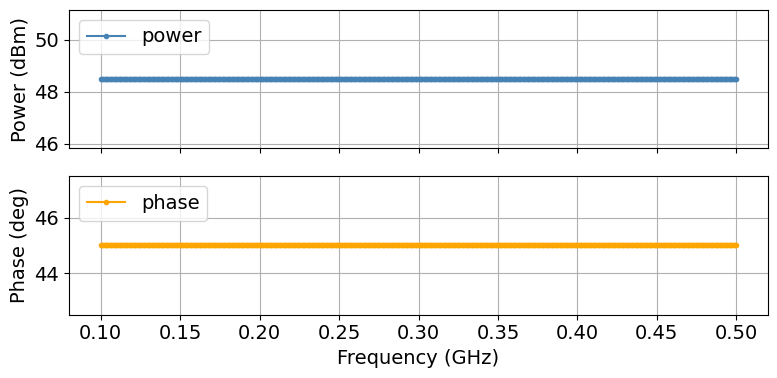

In [9]:
exp_params_cw_res_spec = exp_params_res
exp_params_cw_res_spec.update({
    "exp_name": "cw",
    "wait_after_int": wait_after_int,
    "ro_osc_gain": 0.9,
    "plot_simulation": 0,
})

results_cw_res = res_spectroscopy(session, exp_params_cw_res_spec)

f = np.transpose(np.array(results_cw_res.acquired_results[exp_params_cw_res_spec["exp_name"]].axis))
data  = results_cw_res.acquired_results[exp_params_cw_res_spec["exp_name"]].data
plot_sweeper(f + qudits_params["ro_cent_f"], data)

### Pulsed resonator spectroscopy 

In [10]:
# parameters if output waveforms is pulse
envelop_duration = 2e-6
envelop_amplitude = 1
envelop_width = envelop_duration
envelop_waveform  = pulse_library.gaussian_square(uid = "readout_envelop_q0", length = envelop_duration, amplitude = envelop_amplitude, width = envelop_width, sigma = 0.2)

exp_params_pulse_res_spec = exp_params_res
exp_params_pulse_res_spec.update({
    "exp_name": "pulse",
    "readout_pulse": envelop_waveform,
    "wait_after_int": 5e-6,
    "ro_osc_gain": 0.9,
    "integration_time": integration_time,
})

results_pulse_res = res_spectroscopy(session, exp_params_pulse_res_spec)

f = np.transpose(np.array(results_pulse_res.acquired_results[exp_params_pulse_res_spec["exp_name"]].axis))
data  = results_pulse_res.acquired_results[exp_params_pulse_res_spec["exp_name"]].data
plot_sweeper(f + qudits_params["ro_cent_f"], data)

[2024.02.22 16:03:26.723] INFO    Starting LabOne Q Compiler run...
[2024.02.22 16:03:27.394] INFO    Schedule completed


ValueError: The width of the flat portion of the pulse must be smaller than the total length.

### Sweep frequency and power (2D)

In [11]:
amp_start = 0.1 
amp_stop = 0.9
amp_num_points = 3
amp_sweep = LinearSweepParameter(uid = "amp_sweep_params", start = amp_start, stop = amp_stop, count = amp_num_points)
 
exp_params_2d_res_spec = exp_params_res
exp_params_2d_res_spec.update({
    "exp_name": "2D pulse spec", # or "2D cw spec"
    "readout_pulse": envelop_waveform,
    "wait_after_int": 5e-6,
    "amp_sweep": amp_sweep,
})

results_2d_res = res_spectroscopy(session, exp_params_2d_res_spec)

data  = results_2d_res.acquired_results[exp_params_2d_res_spec["exp_name"]].data
x = results_2d_res.acquired_results[exp_params_2d_res_spec["exp_name"]].axis[1]
y = results_2d_res.acquired_results[exp_params_2d_res_spec["exp_name"]].axis[0]
plot_n(x, y, data, do_plot = 1)
plot_2d(x, y, data, do_plot = 1)


[2024.02.22 16:03:36.377] INFO    Starting LabOne Q Compiler run...
[2024.02.22 16:03:36.490] INFO    Schedule completed


ValueError: The width of the flat portion of the pulse must be smaller than the total length.

### Upload readout parameters after resonator spectroscopy 

In [12]:
# update qudits_params and calibration 
qudits_params.update({
    "ro_cnet_f": 5e9,
    "ro_df": np.linspace(10e6, 200e6, num_qudits),
    "ro_pout_range": 0,
    "ro_pin_range": 0,
    "ro_pulse_data": {k: envelop_waveform for k in lsg_keys}, # note that with software modulation mode, the waveform data will multiply exp(1j*omega_i*t)
    "ro_int_t": exp_params_res["integration_time"],
    "wait_after_int": exp_params_res["wait_after_int"],
})
device_setup.set_calibration(define_calibration(qudits_params))

# Measure propagation delay from the output to input (front panel)

In [13]:
# define delay sweep
delay_start = -100e-9
delay_stop = 500e-9
delay_num_points = 5
delay_sweep = LinearSweepParameter(uid = "delay_sweep", start = delay_start, stop = delay_stop, count = delay_num_points)
delay_num_averages = 8 # number of average is 2^4 = 16

exp_params_prop_delay = {
    "exp_name": "propagation_delay",
    "delay_sweep": delay_sweep,
    "delay_num_averages": delay_num_averages,
    "wait_after_int": 5e-6,
    "plot_simulation": 1,
    "plt_start_time": 0,
    "plt_length":10e-6,
}


# exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
results_exp_delay = propagation_delay(session, exp_params_prop_delay, qudits_params)

f = np.transpose(np.array(results_exp_delay.acquired_results[exp_params_prop_delay["exp_name"]].axis))
data  = results_exp_delay.acquired_results[exp_params_prop_delay["exp_name"]].data
x = results_exp_delay.acquired_results[exp_params_prop_delay["exp_name"]].axis[0]
plot_readout_IQ(int(qudits_params["ro_int_t"]*2e9), data)
plot_qubit_readout_amp_phase(int(qudits_params["ro_int_t"]*2e9), x, np.array(data))


[2024.02.22 16:03:37.880] INFO    Starting LabOne Q Compiler run...
[2024.02.22 16:03:37.884] INFO    Schedule completed


ValueError: The width of the flat portion of the pulse must be smaller than the total length.

In [ ]:
# exp_delay

### Upload measured port delay

In [14]:
qudits_params["ro_int_delay"] = 0
device_setup.set_calibration(define_calibration(qudits_params))

# Qubit Measurements

## Initial settings

In [15]:

qubits = ["q0", "q1"]
num_states = [2, 3]
dr_cent_f = len(qubits) * [5e9]
dr_p_range = len(qubits) * [0]

dr_pulse_t = 200e-9
dr_pulse_amp = len(qubits) * [0.5]
dr_pulse_data = {k: pulse_library.drag(
    uid = f"drive_pulse_{k}",
    length = dr_pulse_t,
    sigma = 0.4,
    beta = 0.2,
    amplitude = dr_pulse_amp[int(k[1])],
 ) for k in qubits
}

exp_params_qubits = { 
    "simulation": 0,
    "qubits": qubits, 
    "num_states": num_states,
    "dr_cent_f": dr_cent_f,
    "dr_p_range": dr_p_range,
    "dr_pulse_data": dr_pulse_data,
    "average_mode": AveragingMode.CYCLIC,
    "wait_after_int": 5e-6,
    "plot_simulation": 1,
    "plt_start_time": 0,
    "plt_length": 100e-6,
    "ro_pulse_g": pulse_library.gaussian_square(uid = "readout_envelop_g", length = envelop_duration, amplitude = 0.1, width = envelop_width, sigma = 0.2),
    "ro_pulse_e": pulse_library.gaussian_square(uid = "readout_envelop_e", length = envelop_duration, amplitude = 0.2, width = envelop_width, sigma = 0.2),
    "ro_pulse_f": pulse_library.gaussian_square(uid = "readout_envelop_f", length = envelop_duration, amplitude = 0.3, width = envelop_width, sigma = 0.2),
}

envelop_duration = 2e-6
envelop_amplitude = 1/len(qubits)
envelop_width = envelop_duration
ro_envelop_waveform  = pulse_library.gaussian_square(uid = "readout_envelop_q0", length = envelop_duration, amplitude = envelop_amplitude, width = envelop_width, sigma = 0.2)
ro_int_weights = pulse_library.gaussian_square(uid = "readout_envelop_q0", length = envelop_duration, amplitude = 1, width = envelop_width, sigma = 0.2)

qudits_params.update({
    "ro_pulse_data": {k: ro_envelop_waveform for k in lsg_keys},
    "ro_int_weights": {k: ro_int_weights for k in lsg_keys},
})

device_setup.set_calibration(define_calibration(qudits_params))

## Qubit spectroscopy

1. qubit spec vs flux (2D sweep)
2. cw (drive) qubit spectroscopy is needed 

### Measure qubit spectroscopy of a single qubit or multiple qubits 

In [16]:
start_freq = -100e6
stop_freq = 100e6
num_points = 501
num_averages = 2
average_mode = AveragingMode.CYCLIC # AveragingMode.SEQUENTIAL #
i = 0
freq_sweep = [LinearSweepParameter(
    uid = f"freq_sweep_" + k, 
    start = start_freq + 0e6 * i, 
    stop = stop_freq + 0e6 * i, 
    count = num_points, 
    axis_name="Frequency [Hz]") for i, k in enumerate(qubits)
]


wait_after_int = 2e-6 + 5e-6
# define the experiment with the frequency sweep relevant for qubit 0
exp_params_qspec = exp_params_qubits
exp_params_qspec.update({
    "exp_name": "qspec",
    "freq_sweep": freq_sweep,
    "num_averages": num_averages,
    "average_mode": average_mode,
    "wait_after_int": wait_after_int,
})

exp_qspec_results = qubit_spec(session, exp_params_qspec, qudits_params)


[2024.02.22 16:03:39.863] INFO    Starting LabOne Q Compiler run...
[2024.02.22 16:03:40.301] INFO    Schedule completed


ValueError: The width of the flat portion of the pulse must be smaller than the total length.

### Upload qubit transition frequencies

In [ ]:
qudits_params.update({
    "qudits": ["q0", "q1"],
    "dr_cent_f": [5e9, 5e9],
    "dr_p_range": [0, 0],
    "dr_df": [10e6, 32e6],
    "dr_pulse_data": dr_pulse_data,
})

device_setup.set_calibration(define_calibration(qudits_params))

## T1 and T2 measurements

### T1

#### Rabi (amplitude sweep)

In [17]:
dr_p_range = [5, 5]
rabi_exp = [LinearSweepParameter(uid=f"amplitude_sweep_{k}", start=0, stop=1, count=4) for k in qubits]

exp_params_rabi_amp = exp_params_qubits
exp_params_rabi_amp.update({
    "exp_name": "rabi_amp",
    "dr_p_range": dr_p_range,
    "amp_sweep": rabi_exp,
    "num_averages": 0,
})

exp_rabi_results = rabi(session, exp_params_rabi_amp, qudits_params)

data = exp_rabi_results.acquired_results[exp_params_rabi_amp["exp_name"] + "_q0"].data

[2024.02.22 16:03:41.141] INFO    Starting LabOne Q Compiler run...
[2024.02.22 16:03:41.147] INFO    Schedule completed


ValueError: The width of the flat portion of the pulse must be smaller than the total length.

#### Upload pi pulse data and T1 

In [18]:
dr_pulse_amp = [0.32, 0.56]
dr_pi_pulse = {k: pulse_library.drag(uid = f"dr_pi_pulse_{k}", length = dr_pulse_t, sigma = 0.4, beta = 0.2, amplitude = dr_pulse_amp[int(k[1])]) for k in qubits}
dr_pi2_pulse = {k: pulse_library.drag(uid = f"dr_pi/2_pulse_{k}", length = dr_pulse_t, sigma = 0.4, beta = 0.2, amplitude = dr_pulse_amp[int(k[1])]/2) for k in qubits}

qudits_params.update({
    "dr_p_range": [0, 0],
    "dr_pi_pulse": dr_pi_pulse,
    "dr_pi/2_pulse": dr_pi2_pulse,
})
device_setup.set_calibration(define_calibration(qudits_params))

IndexError: list index out of range

#### T1 measurement

In [19]:
tau_sweep = [LinearSweepParameter(uid=f"t1_tau_sweep_{k}", start=0, stop=15e-6, count=3) for k in qubits]

exp_params_t1 = exp_params_qubits
exp_params_t1.update({
    "exp_name": "t1",
    "tau_sweep": tau_sweep,
    "num_averages": 0,
})

t1_results = t1(session, exp_params_t1, qudits_params)

data = t1_results.acquired_results[exp_params_t1["exp_name"] + "_q0"].data

[2024.02.22 16:03:41.860] INFO    Starting LabOne Q Compiler run...
[2024.02.22 16:03:41.867] INFO    Schedule completed


ValueError: The width of the flat portion of the pulse must be smaller than the total length.

In [ ]:
qudits_params["T1"] = [100e-6, 80e-6]

### T2

#### T2 (Ramsey)

In [20]:

tau_sweep = [LinearSweepParameter(uid=f"ramsey_tau_sweep_{k}", start=0, stop=15e-6, count=3) for k in qubits]

exp_params_ramsey = exp_params_qubits
exp_params_ramsey.update({
    "exp_name": "ramsey",
    "tau_sweep": tau_sweep,
    "num_averages": 0,
})

ramsey_results = ramsey(session, exp_params_ramsey, qudits_params)

data = ramsey_results.acquired_results[exp_params_ramsey["exp_name"] + "_q0"].data

[2024.02.22 16:03:42.835] INFO    Starting LabOne Q Compiler run...
[2024.02.22 16:03:42.840] INFO    Schedule completed


ValueError: The width of the flat portion of the pulse must be smaller than the total length.

##### Upload T2 Ramsey

In [21]:
qudits_params.update({
    "T2_Ramsey": [100e-6, 80e-6],
})

####  T2 (Hahn Echo)

In [22]:

tau_sweep = [LinearSweepParameter(uid=f"echo_tau_sweep_{k}", start=0, stop=15e-6, count=3) for k in qubits]

exp_params_echo = exp_params_qubits
exp_params_echo.update({
    "exp_name": "hahn echo",
    "tau_sweep": tau_sweep,
    "num_averages": 0,
})

echo_results = hahn_echo(session, exp_params_echo, qudits_params)

data = echo_results.acquired_results[exp_params_echo["exp_name"] + "_q0"].data

[2024.02.22 16:03:43.632] INFO    Starting LabOne Q Compiler run...
[2024.02.22 16:03:43.637] INFO    Schedule completed


ValueError: The width of the flat portion of the pulse must be smaller than the total length.

In [ ]:
qudits_params["T2_echo"] = [100e-6, 80e-6]

#### T2 (CPMG)

In [23]:

tau_sweep = [LinearSweepParameter(uid=f"echo_tau_sweep_{k}", start=0, stop=15e-6, count=3) for k in qubits]

exp_params_cpmg= exp_params_qubits
exp_params_cpmg.update({
    "exp_name": "cpmg",
    "num_cpmg": 3,
    "tau_sweep": tau_sweep,
    "num_averages": 0,
})

cpmg_results = cpmg(session, exp_params_cpmg, qudits_params)

data = cpmg_results.acquired_results[exp_params_cpmg["exp_name"] + "_q0"].data

[2024.02.22 16:03:44.211] INFO    Starting LabOne Q Compiler run...
[2024.02.22 16:03:44.218] INFO    Schedule completed


ValueError: The width of the flat portion of the pulse must be smaller than the total length.

In [ ]:
qudits_params["T2_CPMG"] = [100e-6, 80e-6]

## RB of single-qubit gate

In [24]:
qubits = ["q0", "q1"]
pulse_ref = pulse_library.drag
# pulse_parameters = {"sigma": 0.2}

gate_map = {k: make_pauli_gate_map(
    pi_pulse_amp=qudits_params["dr_pi_pulse"][k].amplitude,
    pi_half_pulse_amp=qudits_params["dr_pi_pulse"][k].amplitude/2,
    excitation_length=qudits_params["dr_pi_pulse"][k].length,
    pulse_factory=pulse_ref,
    pulse_kwargs=qudits_params["dr_pi_pulse"][k].pulse_parameters,
) for k in qubits}

# Different sequence lengths will range from 2^1 to 2^max_seq_length
max_seq_length = 9
seq_lengths = [2**it for it in range(1, max_seq_length + 1)]

# number of different random sequences per length
n_seq_per_length = 10

# the maximum sequence duration is determined by its length,
# the max number of basic gates in each Clifford gate, and the length of each gate
max_seq_duration = 2**max_seq_length * 3 * qudits_params["dr_pi_pulse"]["q0"].length

exp_params_rb_1q = exp_params_qubits
exp_params_rb_1q.update({
    "exp_name": "rb_1q",
    "qubits": qubits,
    "seq_lengths": seq_lengths,
    "n_seq_per_length": n_seq_per_length,
    "max_seq_duration": max_seq_duration,
    "gate_map": gate_map,
    "num_averages": 1,
    "wait_after_int": 5e-6,

})
rb_1q_results = rb_1q(session, exp_params_rb_1q, qudits_params)   
# compiler_settings = {"SHFSG_MIN_PLAYWAVE_HINT": 256}
# compiled_exp_rb_1q = session.compile(exp_rb_1q, compiler_settings=compiler_settings)


# Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# # generate a pulse sheet to inspect experiment before runtime
# show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_exp_rb_1q)

# plot_simulation(compiled_exp_rb_1q, start_time=0, length=200e-6)

# my_results = session.run(compiled_exp_rb_1q)

KeyboardInterrupt: 

In [ ]:
qudits_params["1q_gate_fidelity"] = [0.999, 0.999]